# 2 Этап Анализ данных

In [26]:
# Загрузка библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objs as go
import scipy as sp
import scipy.optimize as spo
from scipy import stats
import statsmodels.api as sm
from itertools import chain
from scipy.stats import shapiro
from scipy.stats import anderson
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
import category_encoders as ce

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from itertools import combinations
from scipy.stats import ttest_ind
%matplotlib inline

## Подгрузим предобработанный датасет

In [2]:
data = pd.read_csv('data/cleaned_data.csv')
display(data.head())
data.info()

,status,baths,city,sqft,zipcode,state,target,pool_encoded,Type,Year built,Heating_encoded,Cooling_encoded,Parking_encoded,fireplace_encoded,school_rating_mean,school_dist_min
0,Active,4.0,Southern Pines,2900,28387,NC,418000,False,single_family_home,2019,True,False,False,True,5.2,2.70
1,For Sale,3.0,Spokane Valley,1947,99216,WA,310000,False,single_family_home,2019,False,False,False,False,4.0,1.01
2,For Sale,2.0,Los Angeles,3000,90049,CA,2895000,True,single_family_home,1961,True,True,True,True,6.7,1.19
3,For Sale,8.0,Dallas,6457,75205,TX,2395000,False,single_family_home,2006,True,True,True,True,5.6,0.10
4,For Sale,0.0,Philadelphia,897,19145,PA,209000,False,townhouse,1920,True,True,False,False,-1.0,-1.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332069 entries, 0 to 332068
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   status              332069 non-null  object 
 1   baths               332069 non-null  float64
 2   city                332060 non-null  object 
 3   sqft                332069 non-null  int64  
 4   zipcode             332069 non-null  int64  
 5   state               332069 non-null  object 
 6   target              332069 non-null  int64  
 7   pool_encoded        332069 non-null  bool   
 8   Type                332069 non-null  object 
 9   Year built          332069 non-null  object 
 10  Heating_encoded     332069 non-null  bool   
 11  Cooling_encoded     332069 non-null  bool   
 12  Parking_encoded     332069 non-null  bool   
 13  fireplace_encoded   332069 non-null  bool   
 14  school_rating_mean  332069 non-null  float64
 15  school_dist_min     332069 non-nul

In [3]:
def visualize_distributions(titles_values_dict, bins=20, color='skyblue'):
    """
    Визуализирует гистограммы для набора числовых признаков.
    Параметры:
    titles_values_dict (dict): словарь, где ключ — название признака, 
                               значение — массив числовых данных.
    bins (int): количество бинов для гистограммы (по умолчанию 20).
    color (str): цвет столбиков гистограммы.
    """
    if not titles_values_dict:
        print("Словарь признаков пуст.")
        return
    num_plots = len(titles_values_dict)
    columns = min(3, num_plots)
    rows = (num_plots - 1) // columns + 1
    fig, axes = plt.subplots(rows, columns, figsize=(columns * 6, rows * 4))
    # Если axes — одномерный массив, преобразуем его к 2D для удобства
    if rows == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    for ax in axes[num_plots:]:
        ax.set_visible(False)  # скрываем лишние оси
    for i, (title, values) in enumerate(titles_values_dict.items()):
        ax = axes[i]
        hist, bins_edges = np.histogram(values, bins=bins)
        width = (bins_edges[1] - bins_edges[0]) * 0.7
        ax.bar(bins_edges[:-1], hist, width=width, color=color, edgecolor='black')
        ax.set_title(title, fontsize=14)
        ax.set_xlabel('Значения', fontsize=12)
        ax.set_ylabel('Частота', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

Функция создает гистограммы для каждого числового признака, используя plt.subplots для более удобного управления осями. Параметры (количество столбцов, размеров) рассчитываются автоматически.

In [4]:
def get_boxplot(column, target_column='target', top_n=10):
    """
    Строит boxplot для категориального признака в зависимости от целевой переменной.
    Параметры:
    column (str): имя категориального признака, который необходимо визуализировать.
    target_column (str): имя столбца целевой переменной (по умолчанию 'target').
    top_n (int): количество наиболее частых категорий для отображения (по умолчанию 10).
    """
    if column not in data.columns:
        print(f"Колонка '{column}' отсутствует в data.")
        return
    if target_column not in data.columns:
        print(f"Целевая колонка '{target_column}' отсутствует в data.")
        return
    # Выбор top_n наиболее частых значений колонки
    top_categories = data[column].value_counts().index[:top_n]
    filtered_data = data[data[column].isin(top_categories)]
    
    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(x=column, y=target_column, data=filtered_data, palette='Set3')
    plt.xticks(rotation=45, fontsize=10)
    plt.xlabel(column, fontsize=12)
    plt.ylabel(target_column, fontsize=12)
    plt.title(f"Boxplot для '{column}' в зависимости от '{target_column}'", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

Функция строит боксплот для столбца 'target', распределенного по топ-10 категориям выбранного признака. Для удобного восприятия категории поворачиваются на 45 градусов.

In [5]:
# Приводим признак 'zipcode' к строковому типу, так как он указывает на район расположения объекта
data['zipcode'] = data['zipcode'].astype(str)
# Проверяем, что признак zipcode теперь строковый
print("Тип данных столбца 'zipcode':", data['zipcode'].dtype)

Тип данных столбца 'zipcode': object


Признак zipcode преобразован в строковый тип, что корректно отражает его смысл как идентификатор района, а не числовые значения.

In [6]:
# Составляем список булевых признаков
bin_features = ['pool_encoded', 'Heating_encoded', 'Cooling_encoded', 'Parking_encoded', 'fireplace_encoded']
print("Булевые признаки:", bin_features)

# Составляем список категориальных признаков
cat_features = ['status', 'city', 'zipcode', 'state', 'Type', 'Year built']
print("Категориальные признаки:", cat_features)

# Составляем список числовых признаков
num_features = ['baths', 'sqft', 'target', 'school_rating_mean', 'school_dist_min']
print("Числовые признаки:", num_features)

Булевые признаки: ['pool_encoded', 'Heating_encoded', 'Cooling_encoded', 'Parking_encoded', 'fireplace_encoded']
Категориальные признаки: ['status', 'city', 'zipcode', 'state', 'Type', 'Year built']
Числовые признаки: ['baths', 'sqft', 'target', 'school_rating_mean', 'school_dist_min']


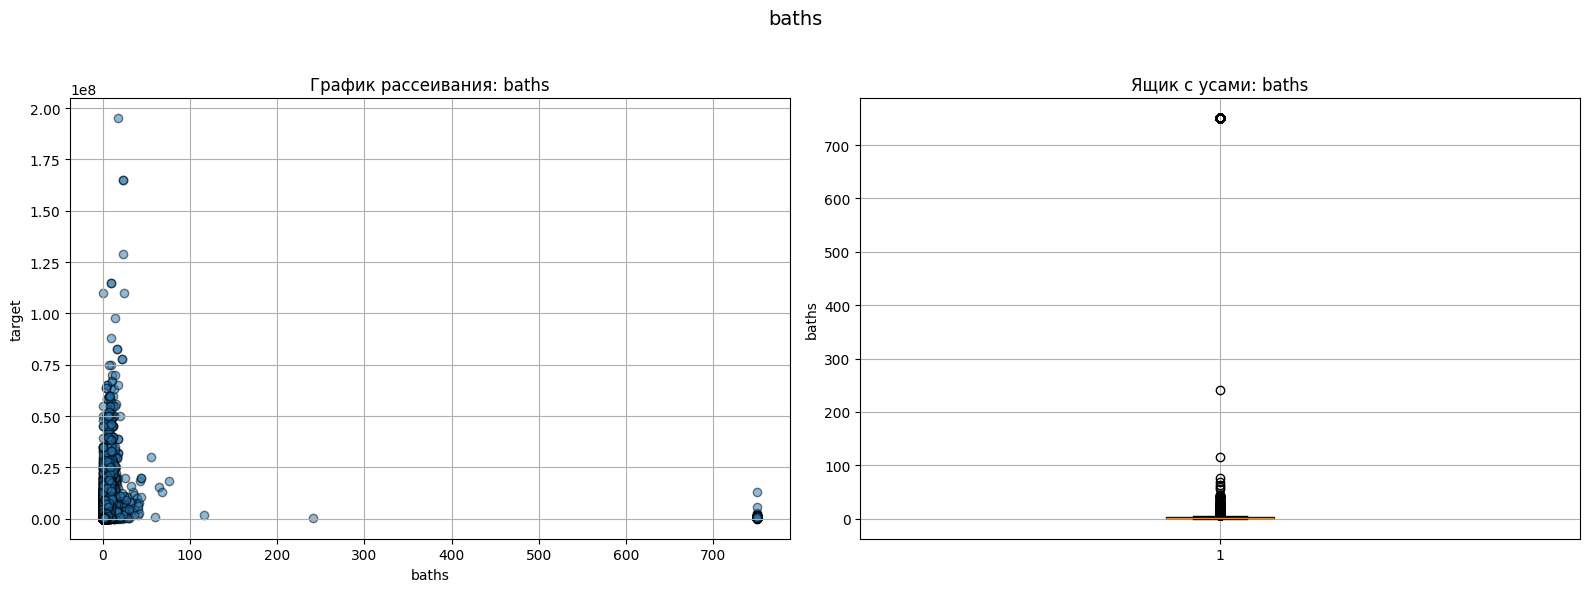

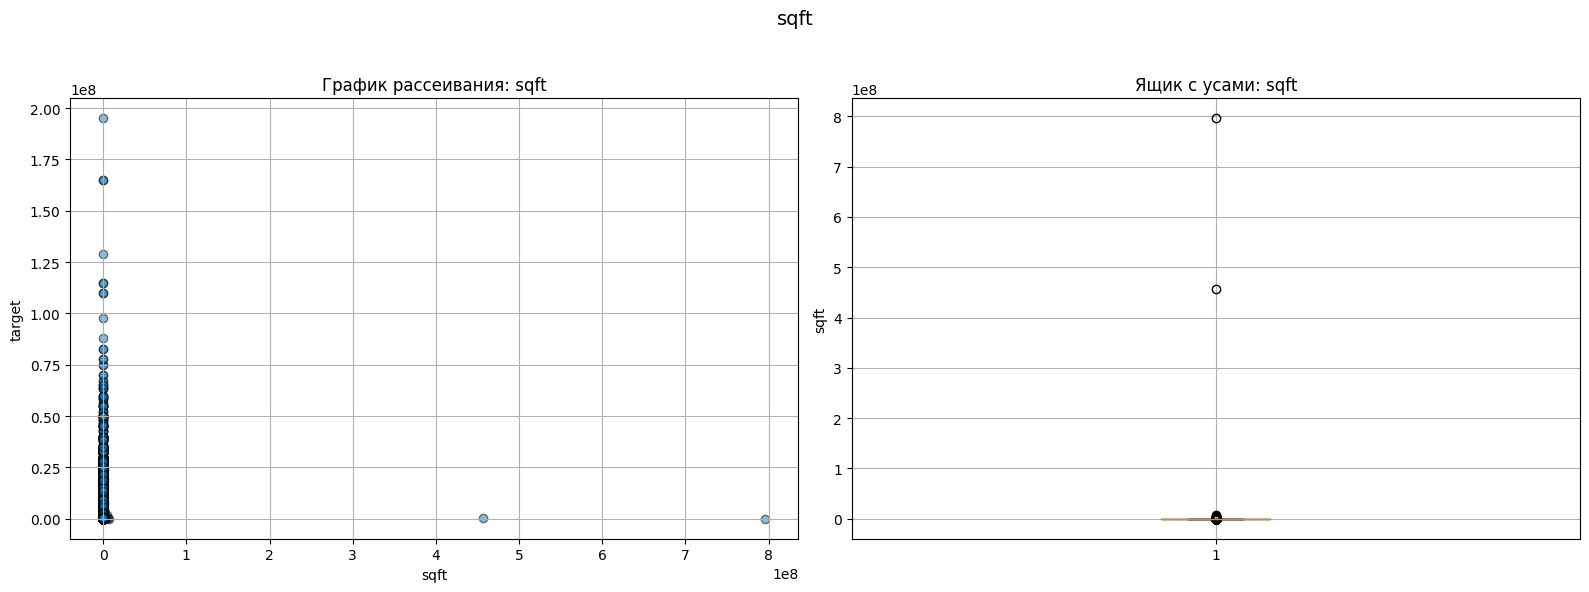

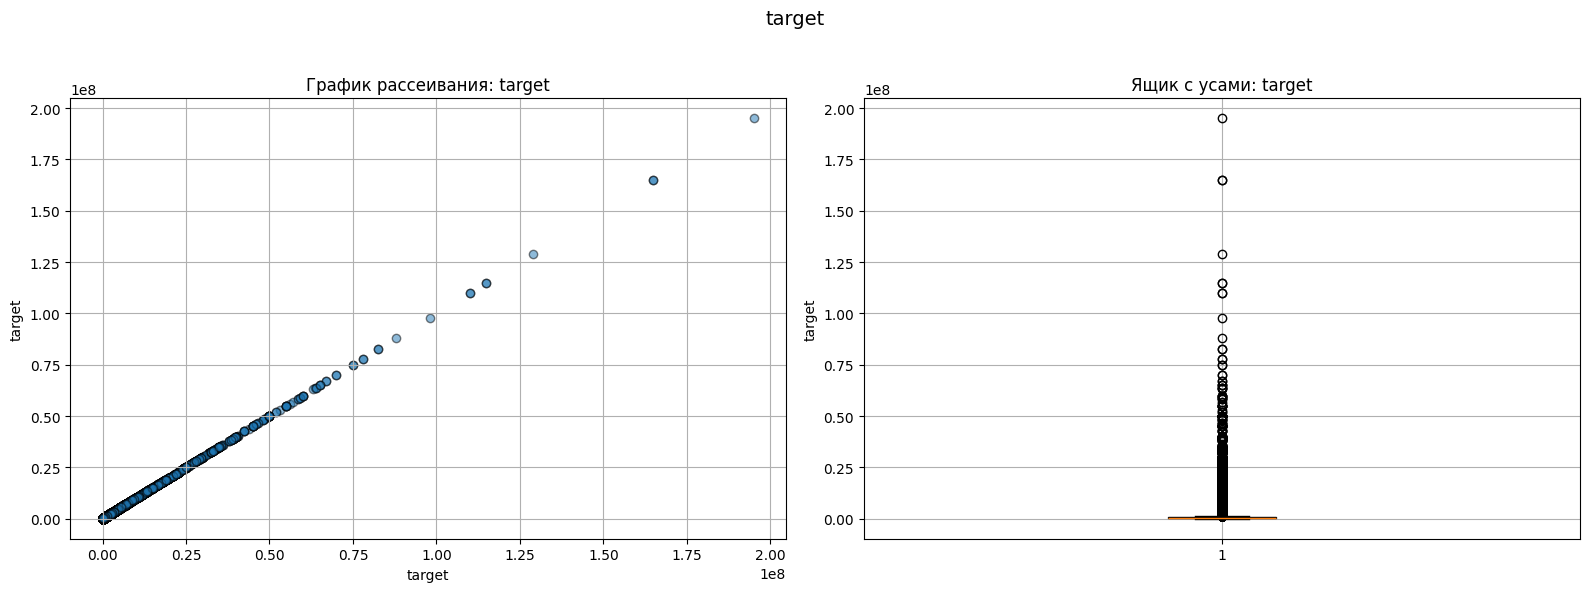

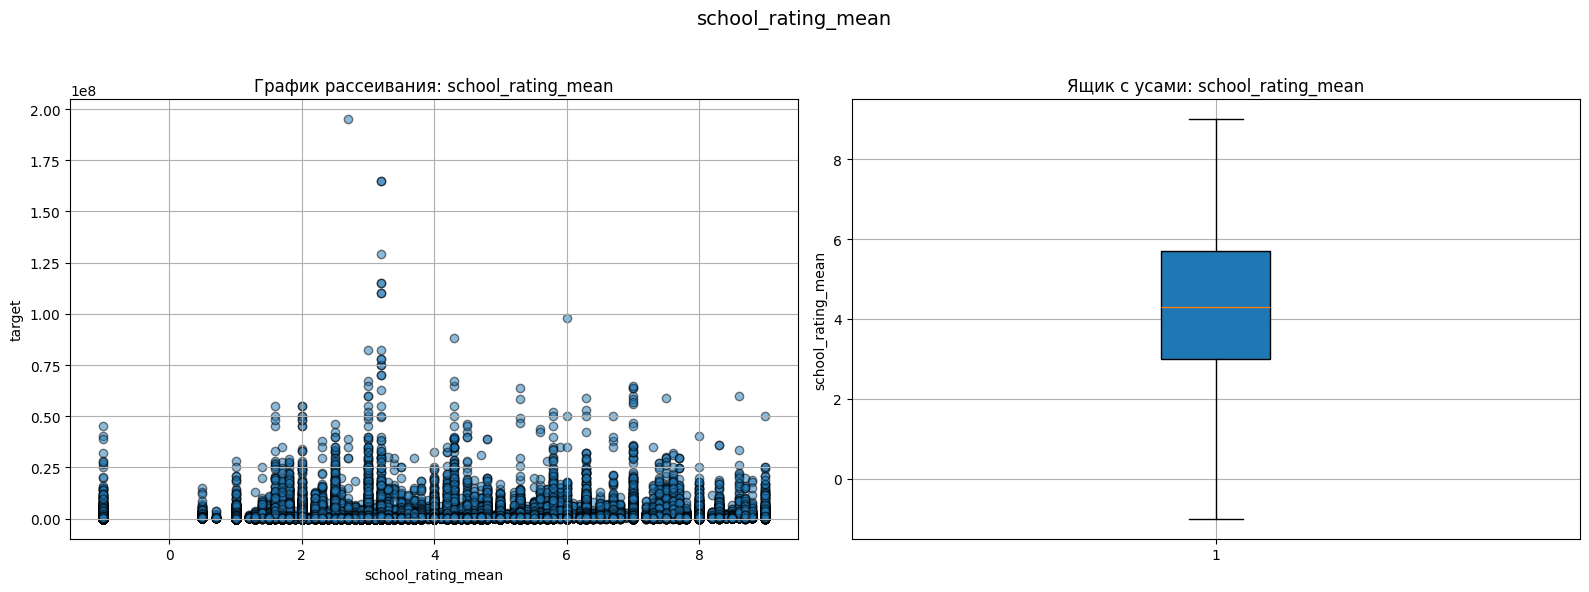

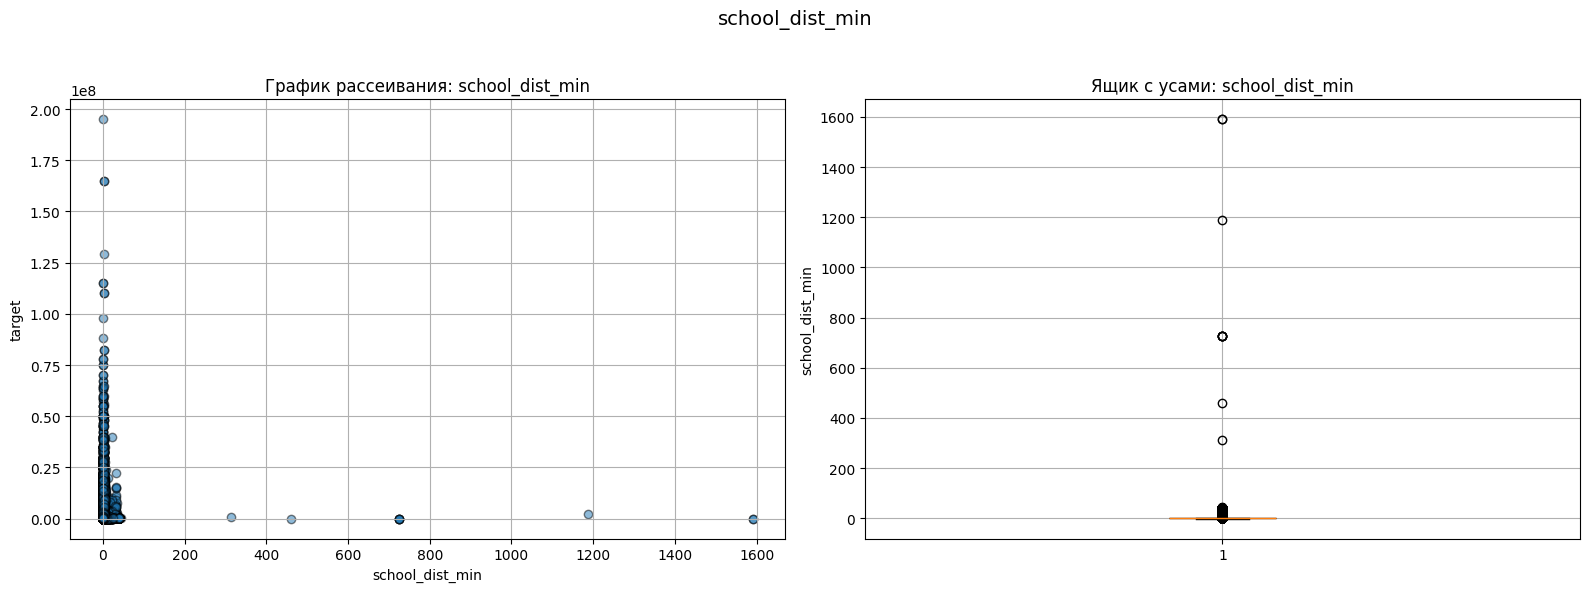

In [7]:
for feature in num_features:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(feature, fontsize=14)
    
    # График рассеивания
    ax1.scatter(data[feature], data['target'], alpha=0.5, edgecolor="k")
    ax1.set_title(f'График рассеивания: {feature}', fontsize=12)
    ax1.set_xlabel(feature, fontsize=10)
    ax1.set_ylabel('target', fontsize=10)
    ax1.grid(True)
    # Ящик с усами (Boxplot) с учётом возможных пропущенных значений
    ax2.boxplot(data[feature].dropna(), vert=True, patch_artist=True)
    ax2.set_title(f'Ящик с усами: {feature}', fontsize=12)
    ax2.set_ylabel(feature, fontsize=10)
    ax2.grid(True)
    
    # Корректировка размещения элементов на графике
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

Вывод:

- Ванные комнаты больше 100, 200 и 700. Такие экстремально высокие значения в сравнении с общим распределением могут быть ошибками ввода, выбросами или, в редких случаях, реальными данными для особых объектов (например, гостиниц или коммерческой недвижимости). Проверим данные на выбросы.
- В площади скорее всего тоже присутвую выбросы данных.
- По школам расстояние больше 200 

In [8]:
# выведем интересующие нас строки
condition = (data['baths'].isin([116,241,750]))
filtered_df = data[condition]
# Вывести отфильтрованные строки
display(filtered_df.head(5))
# Подсчет среднего значения 'sqft'
average_sqft = filtered_df['sqft'].mean()
# Вывести среднее значение 'sqft'
print("Среднее значение sqft: ", average_sqft)

,status,baths,city,sqft,zipcode,state,target,pool_encoded,Type,Year built,Heating_encoded,Cooling_encoded,Parking_encoded,fireplace_encoded,school_rating_mean,school_dist_min
981,Active,750.0,Dallas,1758,75219,TX,499000,False,other,1993,False,True,False,True,2.6,0.9
1788,Active,750.0,Washington,1367,20001,DC,1499000,False,other,2013,False,False,False,False,6.8,0.3
3157,Active,750.0,Denver,873,80204,CO,348900,False,other,1981,True,True,False,False,4.0,0.2
6664,Active,750.0,Denver,1864,80204,CO,560000,False,other,1936,True,False,False,False,2.0,0.5
6784,Active,750.0,Dallas,1336,75219,TX,285000,False,condo,1984,False,True,False,True,2.0,1.0


Среднее значение sqft:  2101.8870292887027


воспользовавшись гугл поиском проверил адреса с значением 750 ванных все это квартиры имеющие в среднем 2 ванные комнаты удалим эти выбросы.

In [9]:
# Удаляем Выбросы, соответствующие условию
data.drop(data[condition].index, inplace=True)

In [10]:
condition1 = ((data['sqft'] == 0) & (data['target'] == 195000000)) | (data['sqft'] > 455000000)
filtered1_df = data[condition1]
# Вывести отфильтрованные строки
display(filtered1_df)

,status,baths,city,sqft,zipcode,state,target,pool_encoded,Type,Year built,Heating_encoded,Cooling_encoded,Parking_encoded,fireplace_encoded,school_rating_mean,school_dist_min
55333,For Sale,2.0,Cincinnati,795979430,45225,OH,27500,False,single_family_home,1901,True,True,True,True,2.5,0.78
116575,For Sale,18.0,Los Angeles,0,90077,CA,195000000,True,single_family_home,1935,True,True,True,True,2.7,1.30
331500,Active,0.0,Glendale,456602479,42740,KY,198000,False,multi_family_home,2012,True,True,False,False,6.3,3.10


In [11]:
# Удаляем Выбросы, соответствующие условию
data.drop(data[condition1].index, inplace=True)

In [12]:
condition2 = (data['school_dist_min']> 200)
filtered2_df = data[condition2]
# Вывести отфильтрованные строки
print(len(filtered2_df))
display(filtered2_df.head(5))

10


,status,baths,city,sqft,zipcode,state,target,pool_encoded,Type,Year built,Heating_encoded,Cooling_encoded,Parking_encoded,fireplace_encoded,school_rating_mean,school_dist_min
23357,Other,4.0,Falcon Heights,6000,78545,TX,670000,False,single_family_home,1980,True,True,True,False,2.5,312.40
96956,For Sale,0.0,Santa Ana,890,92703,TN,48640,False,single_family_home,1963,True,True,False,True,2.7,1590.36
149265,For Sale,0.0,Spring,720,77380,TN,18000,False,single_family_home,1950,True,False,False,True,7.5,460.86
179706,For Sale,6.0,Miami Beach,4173,33140,FL,2350000,True,single_family_home,1949,True,False,True,False,5.5,1187.14
190277,For Sale,3.0,Needmore,1230,17238,TN,57225,False,single_family_home,1953,True,True,False,True,5.5,725.17


In [13]:
# Удаляем Выбросы, соответствующие условию
data.drop(data[condition2].index, inplace=True)

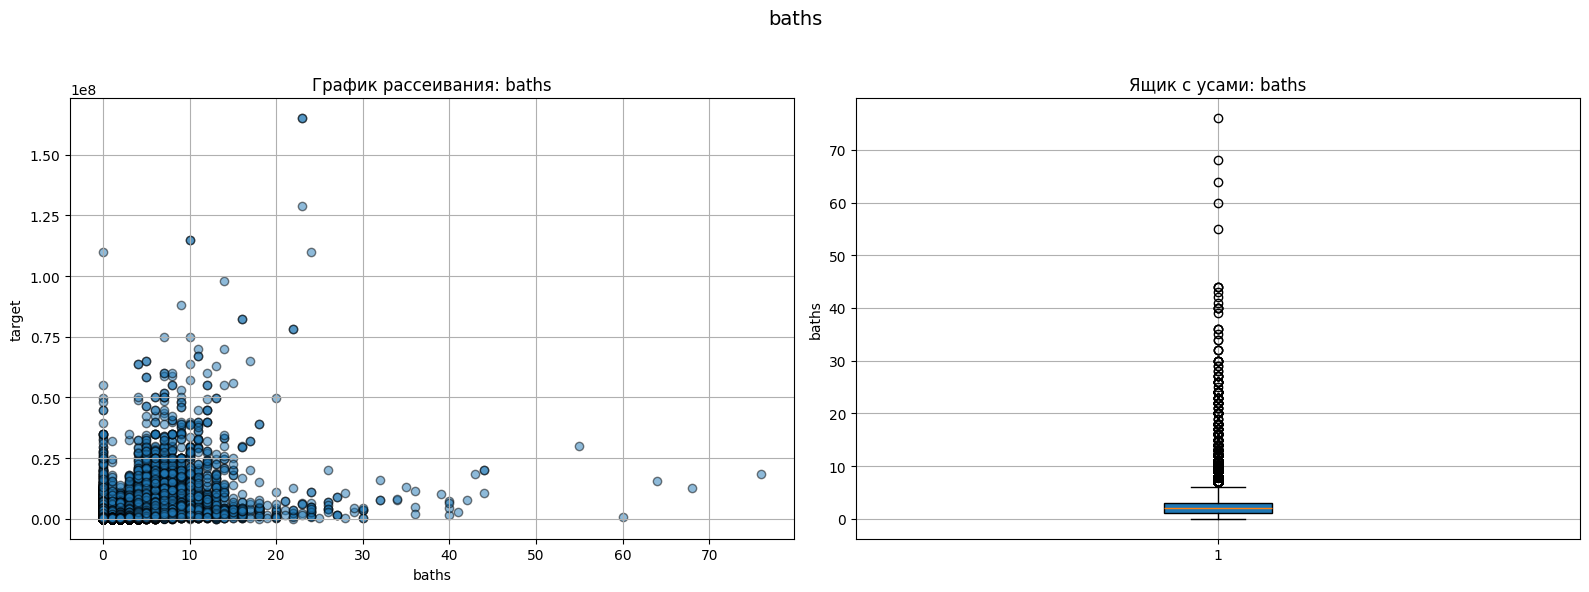

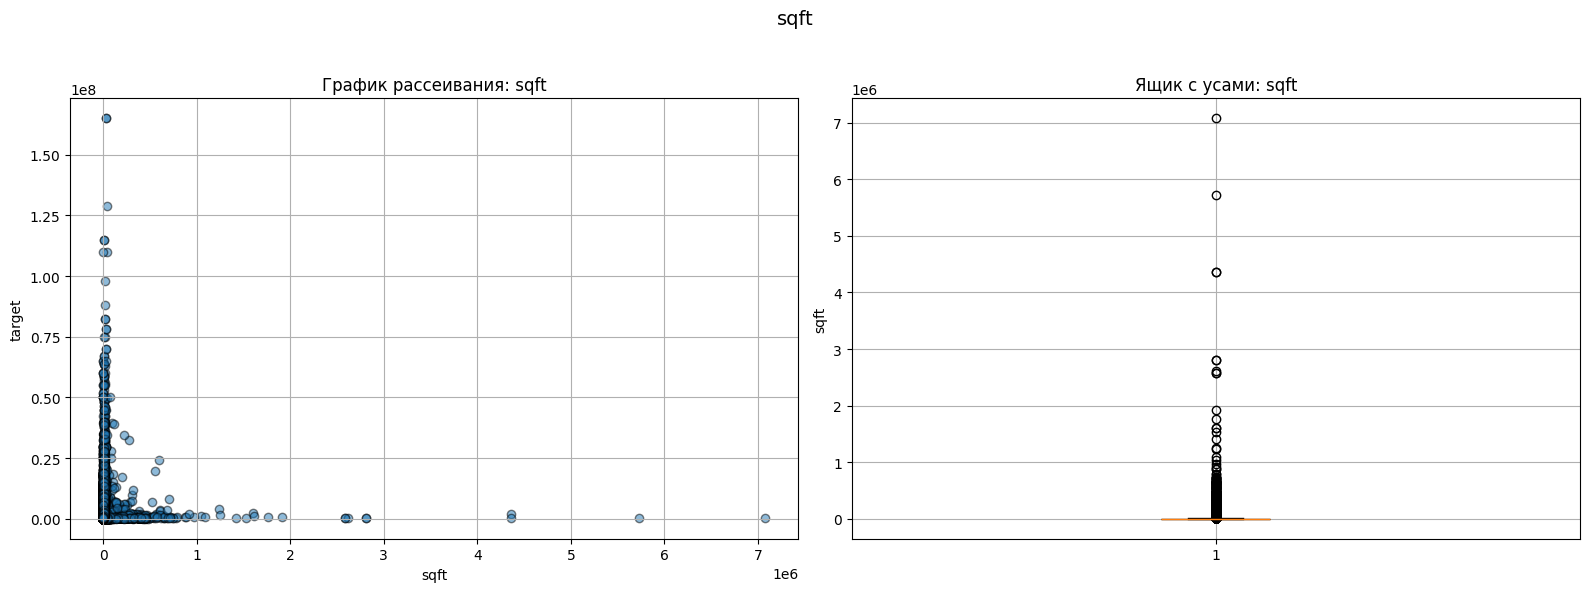

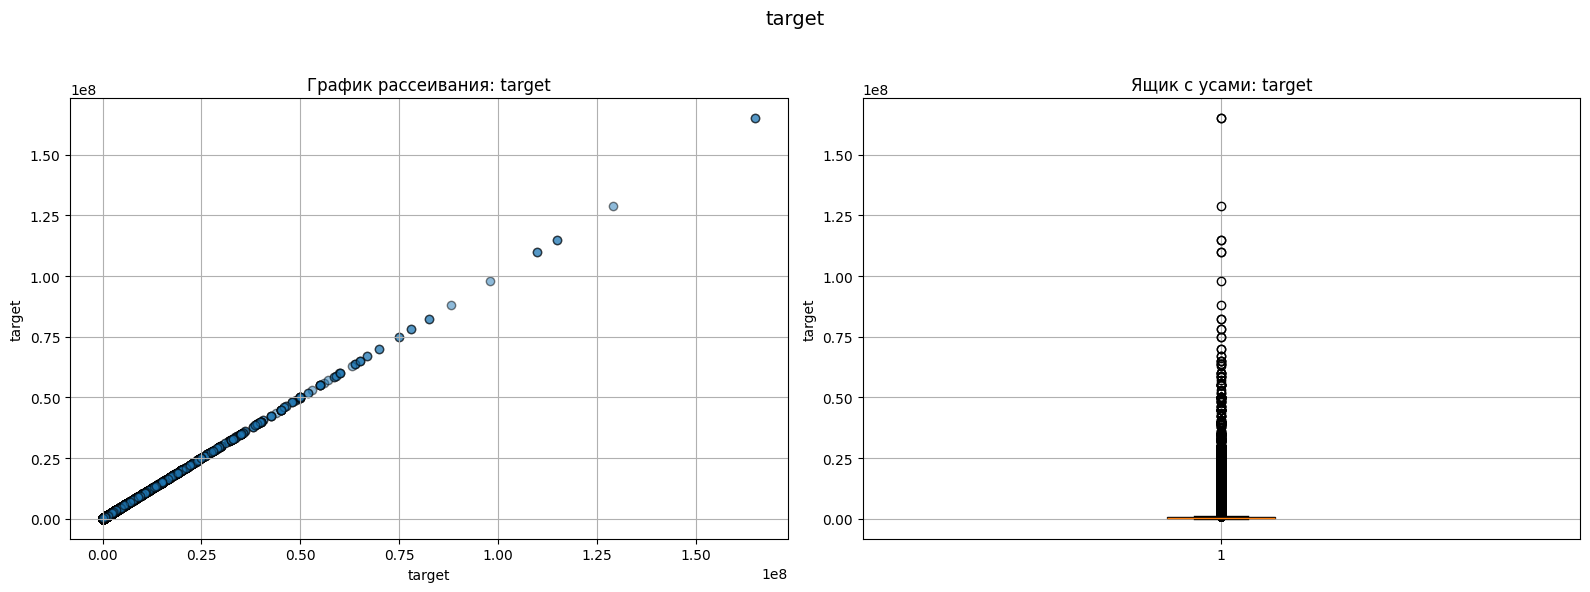

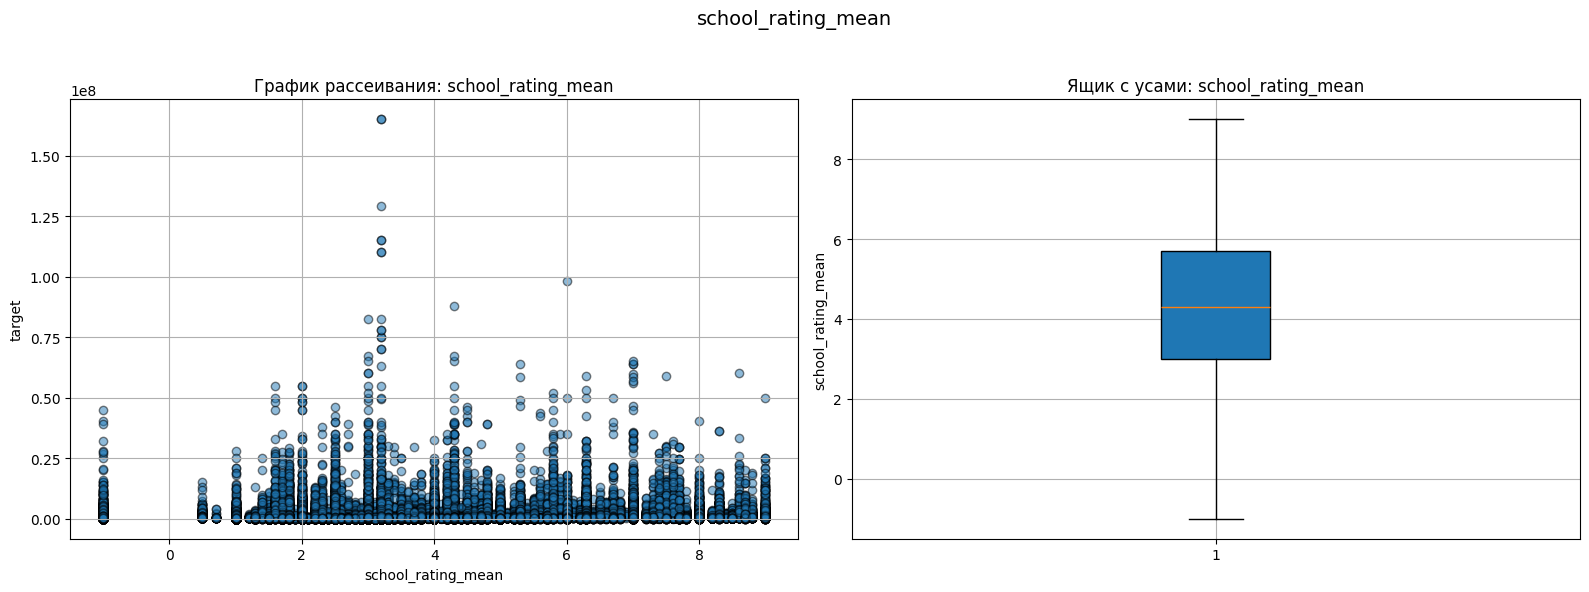

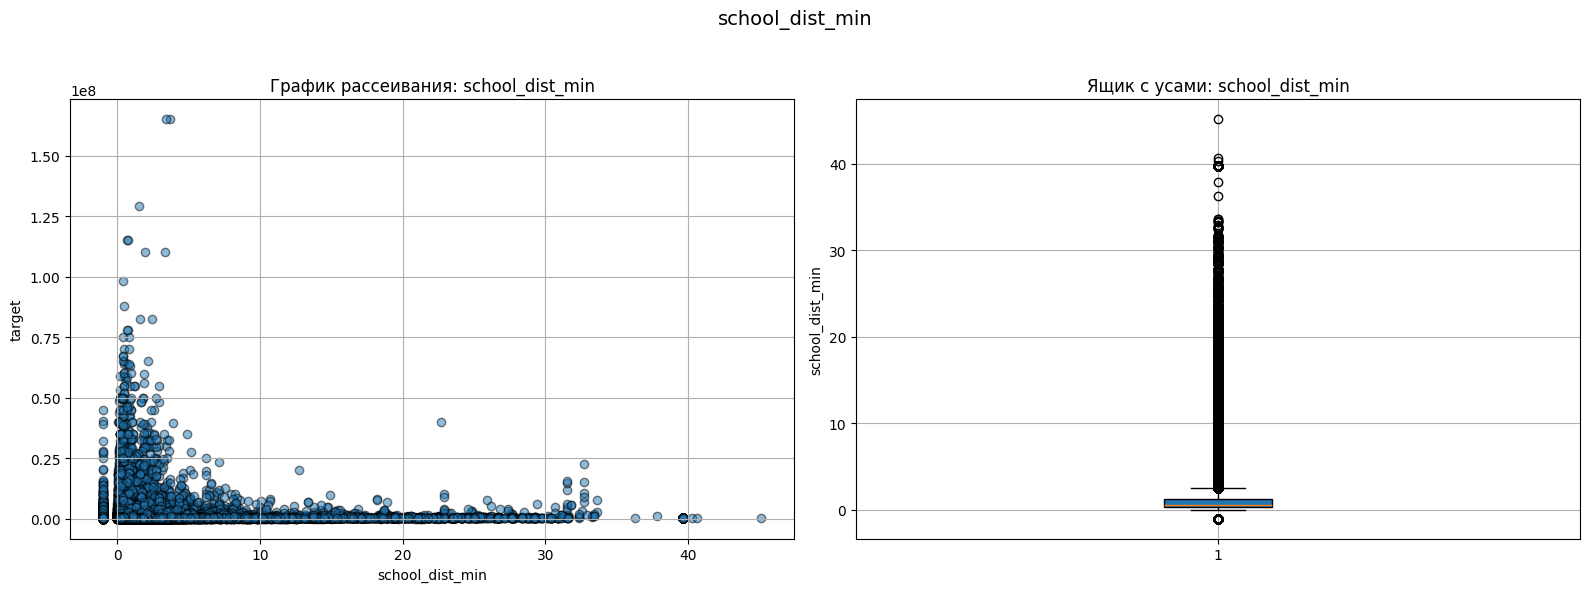

In [14]:
for feature in num_features:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(feature, fontsize=14)
    
    # График рассеивания
    ax1.scatter(data[feature], data['target'], alpha=0.5, edgecolor="k")
    ax1.set_title(f'График рассеивания: {feature}', fontsize=12)
    ax1.set_xlabel(feature, fontsize=10)
    ax1.set_ylabel('target', fontsize=10)
    ax1.grid(True)
    # Ящик с усами (Boxplot) с учётом возможных пропущенных значений
    ax2.boxplot(data[feature].dropna(), vert=True, patch_artist=True)
    ax2.set_title(f'Ящик с усами: {feature}', fontsize=12)
    ax2.set_ylabel(feature, fontsize=10)
    ax2.grid(True)
    
    # Корректировка размещения элементов на графике
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

Остались сомнительные значения посмотрим на них

In [15]:
# Формирование условия фильтрации
condition = (
    (data['baths'] > 30) |
    (data['target'] > 750000) |
    (data['sqft'] > 200000) |
    (data['school_dist_min'] > 35)
)
# Применение фильтрации к датафрейму
filtered_data = data[condition]
# Вывод количества найденных строк и первых 5 записей из отфильтрованных данных
print(f"Найдено строк: {len(filtered_data)}")
display(filtered_data.head(5))

Найдено строк: 59254


,status,baths,city,sqft,zipcode,state,target,pool_encoded,Type,Year built,Heating_encoded,Cooling_encoded,Parking_encoded,fireplace_encoded,school_rating_mean,school_dist_min
2,For Sale,2.0,Los Angeles,3000,90049,CA,2895000,True,single_family_home,1961,True,True,True,True,6.7,1.19
3,For Sale,8.0,Dallas,6457,75205,TX,2395000,False,single_family_home,2006,True,True,True,True,5.6,0.10
14,For Sale,0.0,Brooklyn,0,11219,NY,1650000,False,single_family_home,1905,False,True,False,False,6.3,0.20
16,Active,0.0,New York,3325,10027,NY,2650000,False,townhouse,1899,False,False,False,False,2.5,0.10
20,For Sale,5.0,Bend,5266,97702,OR,3500000,False,single_family_home,2008,True,True,True,True,6.3,3.70


In [16]:
# Удаляем выбросы, удовлетворяющие условию
data.drop(data[condition].index, inplace=True)
print(f"Выбросы удалены. Осталось записей: {len(data)}")

Выбросы удалены. Осталось записей: 272563


In [17]:
# Формируем условие для выборки неверных значений: где количество ванных комнат или площадь меньше 1
condition = (data['baths'] < 1) | (data['sqft'] < 1)
# Фильтруем датафрейм по условию
filtered4_data = data[condition]
# Выводим количество строк, удовлетворяющих условию, и первые пять строк результата
print(f"Найдено строк: {len(filtered4_data)}")
display(filtered4_data.head(5))

Найдено строк: 61744


,status,baths,city,sqft,zipcode,state,target,pool_encoded,Type,Year built,Heating_encoded,Cooling_encoded,Parking_encoded,fireplace_encoded,school_rating_mean,school_dist_min
4,For Sale,0.0,Philadelphia,897,19145,PA,209000,False,townhouse,1920,True,True,False,False,-1.0,-1.00
5,Active,0.0,Poinciana,1507,34759,FL,181500,False,other,2006,True,True,False,False,2.3,0.80
6,Active,0.0,Memphis,0,38115,TN,68000,False,other,1976,False,False,False,False,2.7,0.40
10,Active,0.0,Houston,3130,77068,TX,260000,False,other,2015,True,True,False,False,4.2,0.40
34,For Sale,0.0,Charlotte,900,28202,NC,260000,False,condo,1981,False,False,False,False,6.3,0.48


In [18]:
# Удаляем выбросы, удовлетворяющие условию
data.drop(data[condition].index, inplace=True)
# Выводим количество оставшихся записей для подтверждения изменений в датафрейме
print(f"После удаления выбросов осталось записей: {len(data)}")

После удаления выбросов осталось записей: 210819


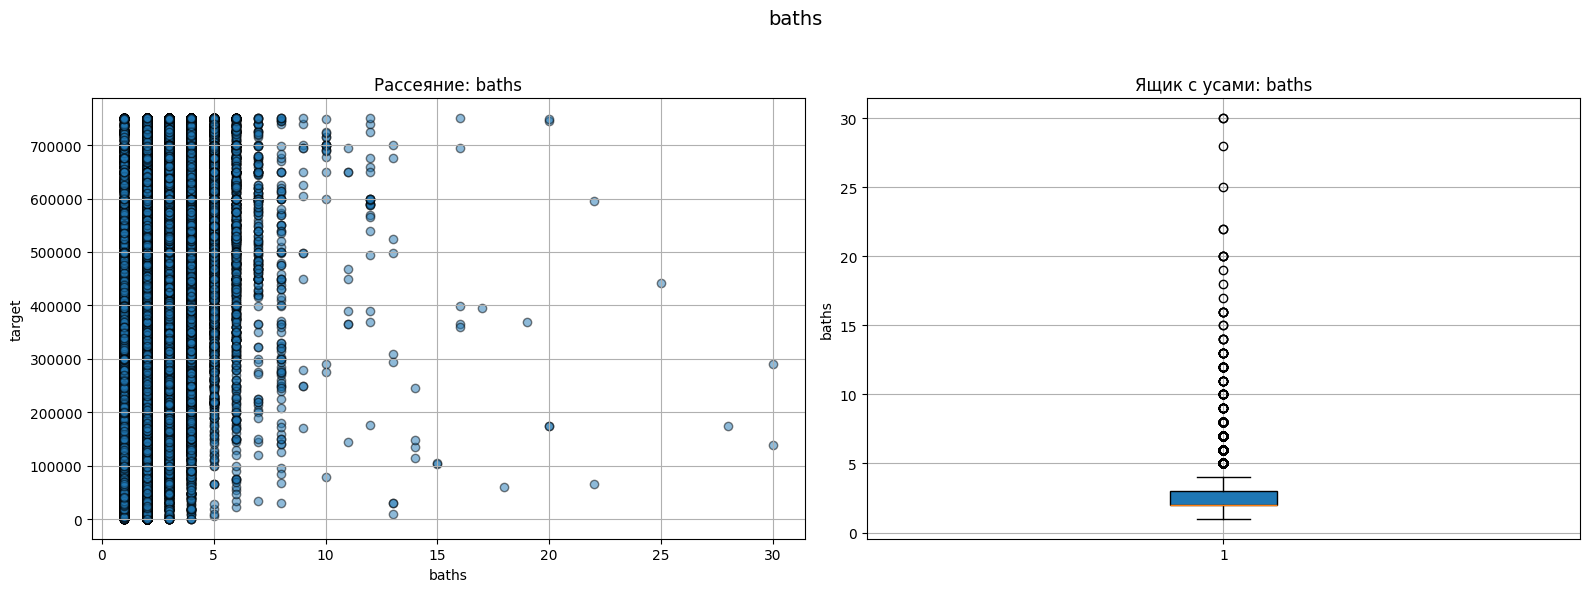

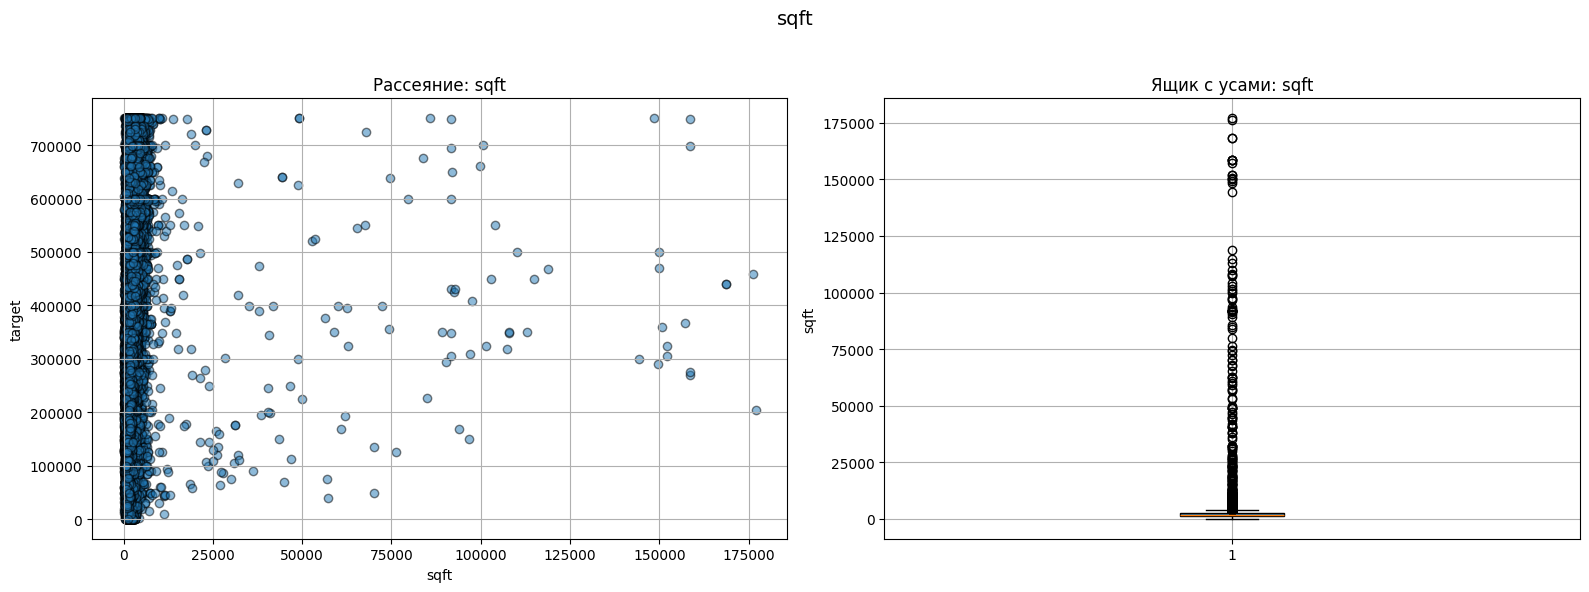

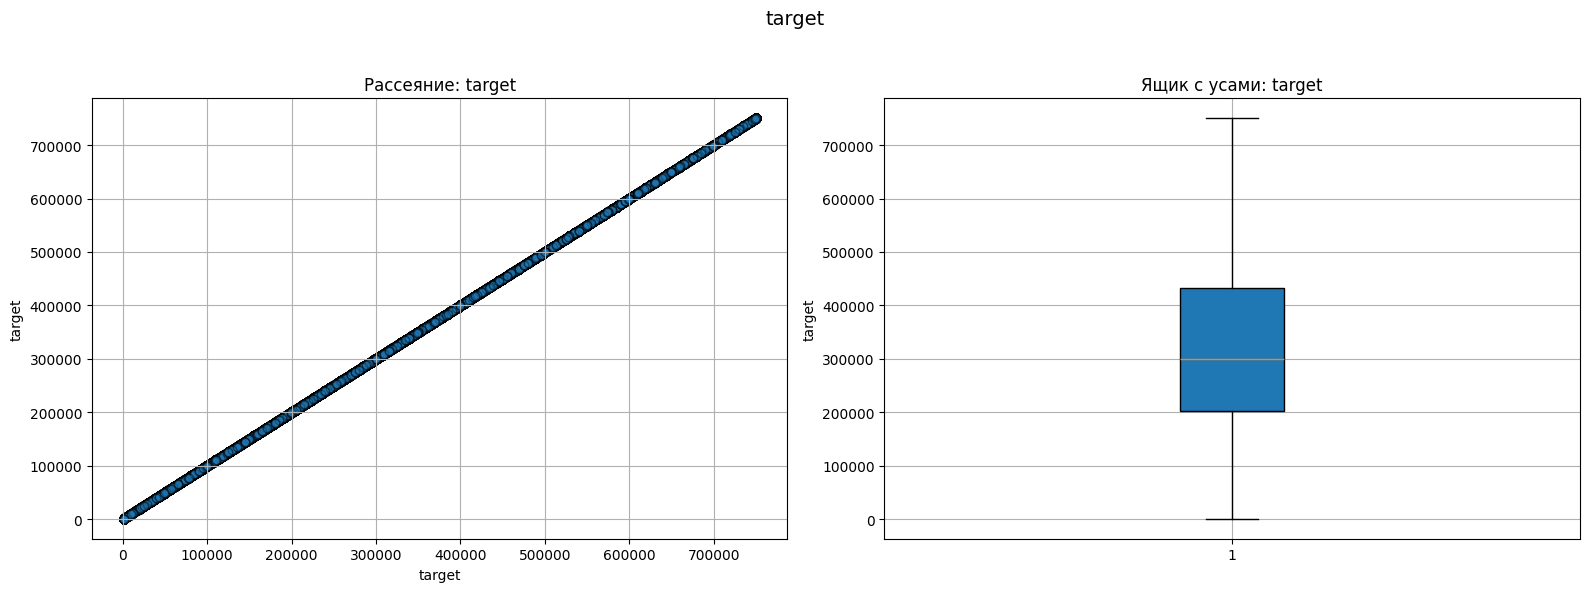

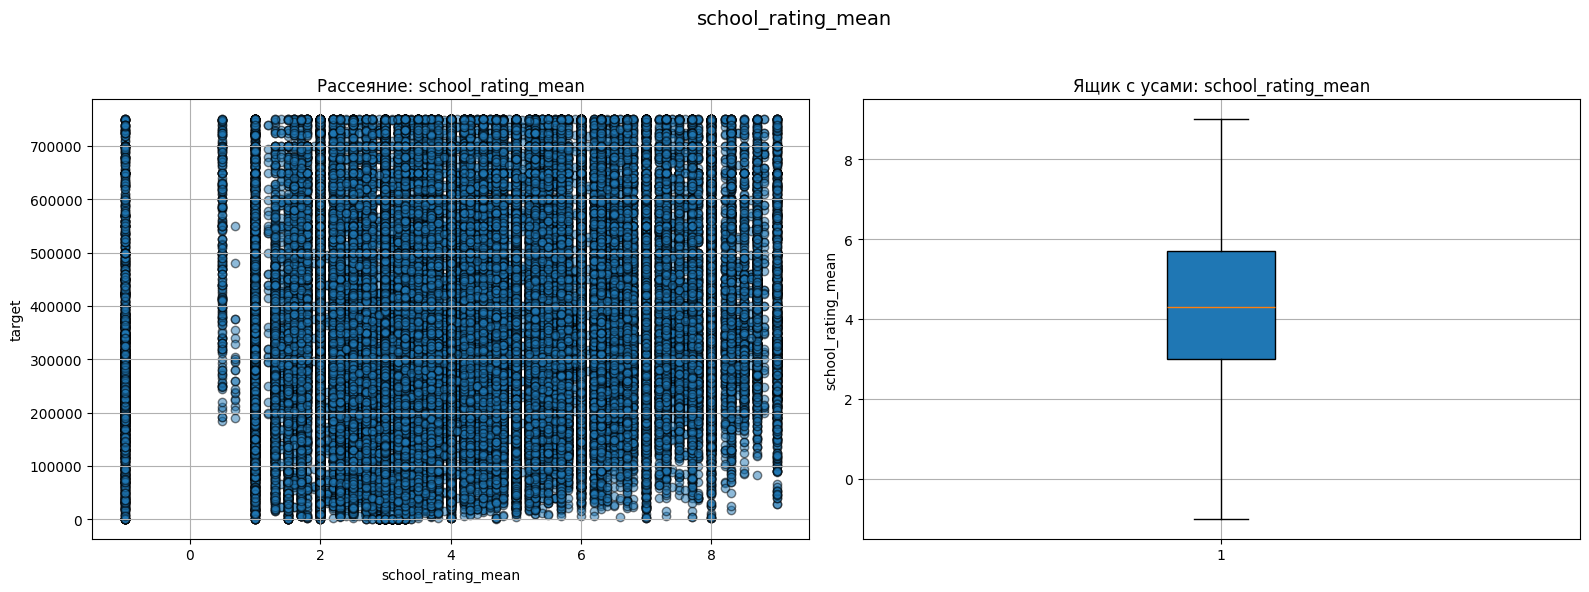

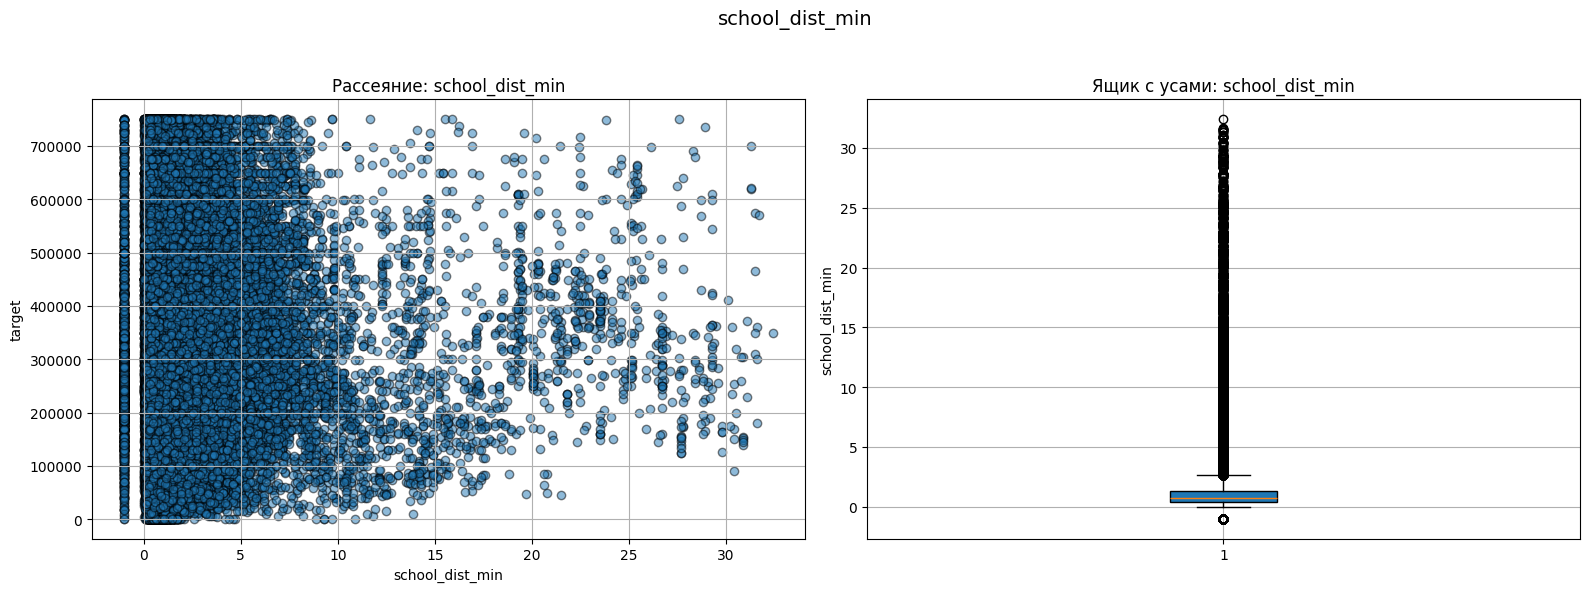

In [19]:
# Перебираем числовые признаки для построения графиков
for feature in num_features:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(feature, fontsize=14)
    # График рассеивания (scatter plot)
    ax1.scatter(data[feature], data['target'], alpha=0.5, edgecolor='k')
    ax1.set_title(f'Рассеяние: {feature}', fontsize=12)
    ax1.set_xlabel(feature, fontsize=10)
    ax1.set_ylabel('target', fontsize=10)
    ax1.grid(True)
    # Ящик с усами (boxplot)
    # Используем dropna(), чтобы избежать ошибок из-за пропусков
    ax2.boxplot(data[feature].dropna(), patch_artist=True)
    ax2.set_title(f'Ящик с усами: {feature}', fontsize=12)
    ax2.set_ylabel(feature, fontsize=10)
    ax2.grid(True)
    # Корректировка расположения элементов на фигуре
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

- График Baths:
    * Scatter Plot:
        - Точки распределены неравномерно: Большинство значений переменной baths находятся в диапазоне от 0 до 5, с небольшим количеством наблюдений для значений выше 6.
    * Box Plot:
        - Медиана и размах: Ящик с усами показывает, что медианное значение baths вокруг 1, что указывает на небольшой средний размер ванн в наблюдаемой выборке.
- График sqft:
    * Scatter Plot:
        - Склонность к выравниванию: Точки разброса начинают сгруппироваться и выстраиваться в некоторую направленность, что свидетельствует о вероятной линейной зависимости.
    * Box Plot:
        - Медиана и размах: Медиана sqft находится в пределах нормального диапазона. Однако, данные о выбросах в верхней части могут указывать на наличие объектов с аномально большой площадью.


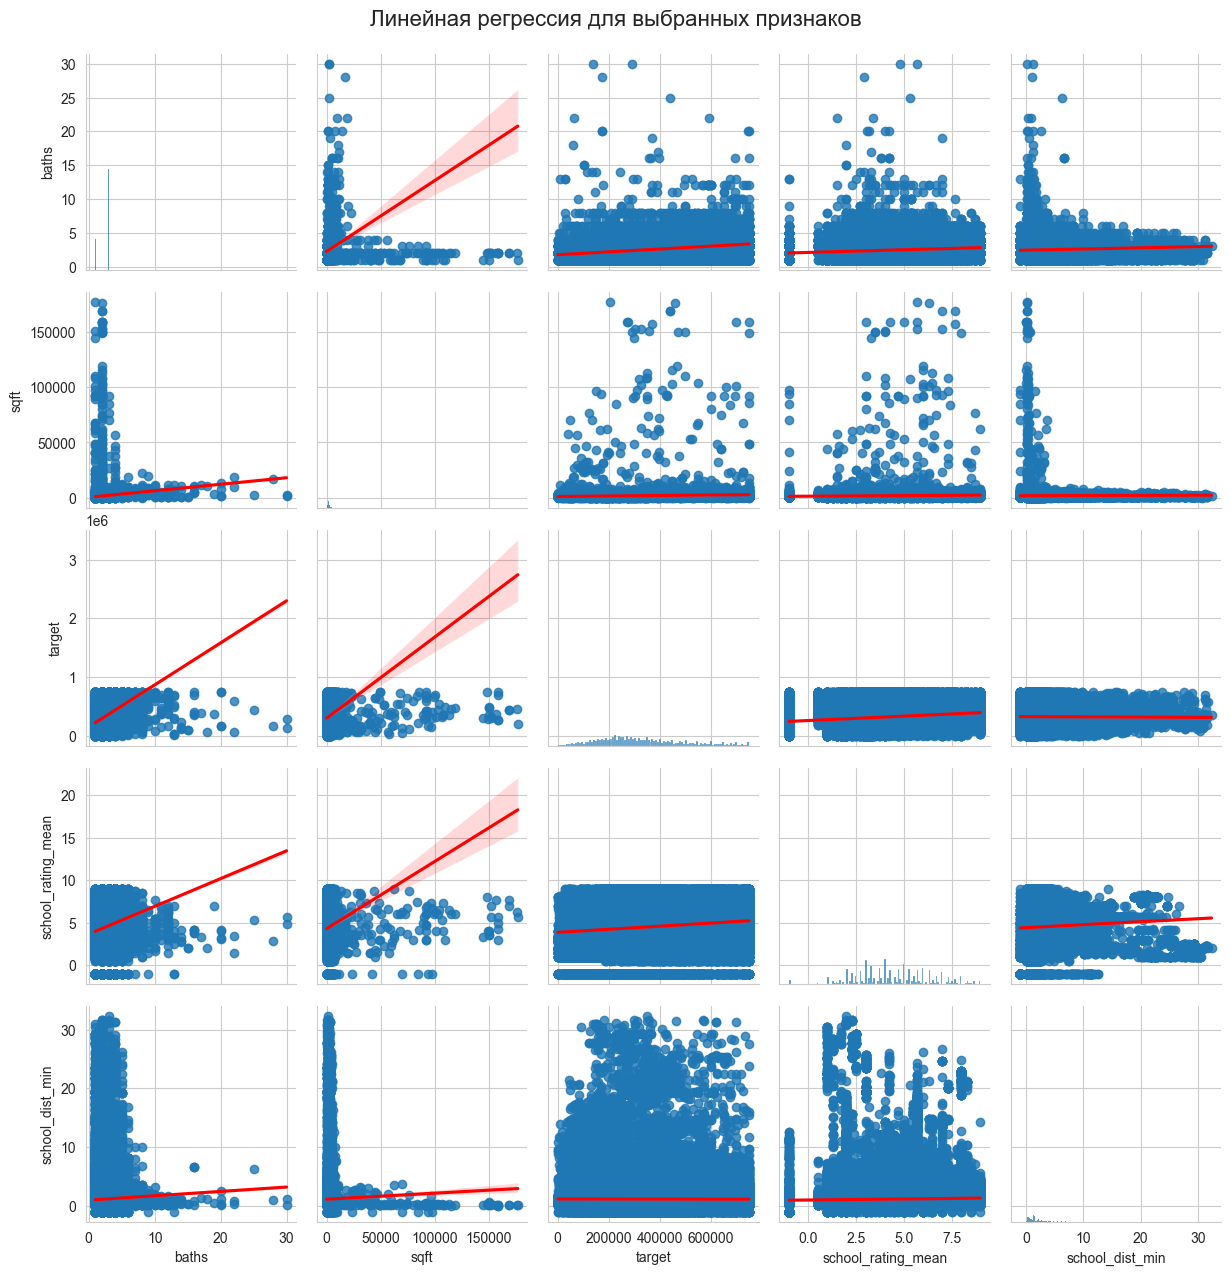

In [20]:
# Отбираем нужные числовые признаки из датафрейма и создаем копию
data_selected = data[num_features].copy()
# Настраиваем стиль seaborn для лучшей визуализации
sns.set_style("whitegrid")
# Строим парный график с регрессионными линиями
pair_plot = sns.pairplot(
    data_selected,
    kind="reg",
    plot_kws={"line_kws": {"color": "red"}},
    diag_kws={"line_kws": {"color": "red"}}
)
# Добавляем заголовок (с небольшим смещением по вертикали для правильного расположения)
pair_plot.fig.suptitle("Линейная регрессия для выбранных признаков", fontsize=16, y=1.02)
# Сохраняем полученный график в файл формата PNG с оптимизированным расположением элементов
plt.savefig("image/plot.png", format="png", bbox_inches="tight")
# Отображаем график
plt.show()

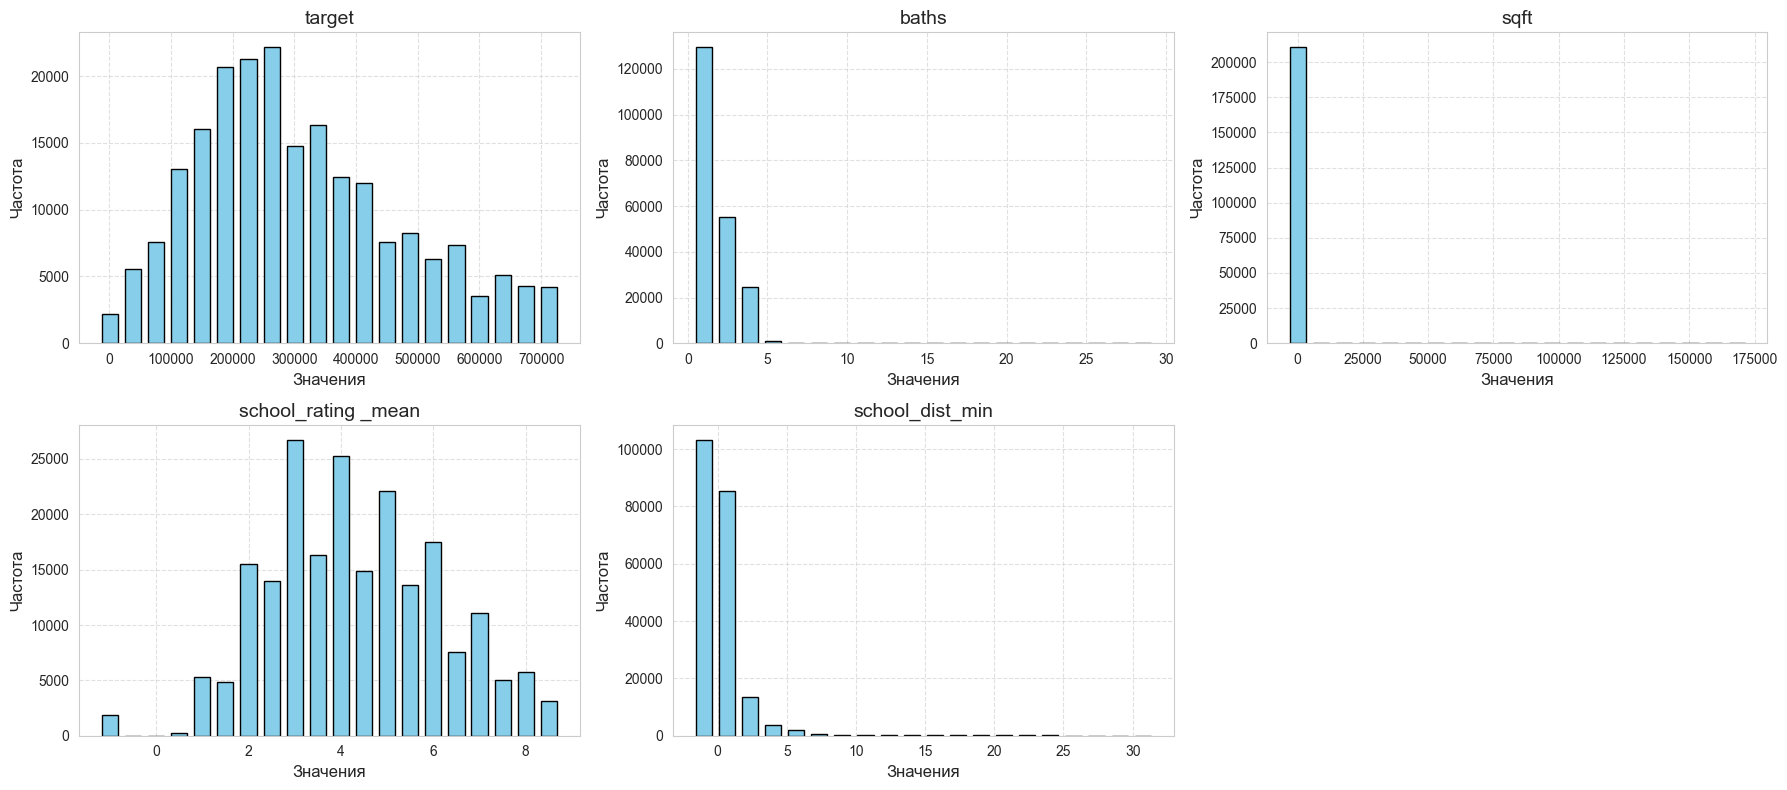

In [21]:
visualize_distributions({ 
    'target': data['target'], 
    'baths': data['baths'], 
    'sqft': data['sqft'], 
    'school_rating _mean': data['school_rating_mean'], 
    'school_dist_min': data['school_dist_min'], 
})

- Распространение переменных:
    * Неравномерные распределения: Для всех переменных наблюдаются различные формы распределений, которые явно не нормальные. Например, высокий пик на низких значениях и быстрое уменьшение частоты по мере увеличения значений.
- Необходимость нормализации:
    * Логарифмическое преобразование: Для получения более нормального распределения может потребоваться нормализация переменных, например, с использованием логарифмического преобразования. Это улучшит обработку данных и повысит эффективность моделирования.

Ранг матрицы корреляций: 5
Определитель матрицы корреляций: 0.7562493


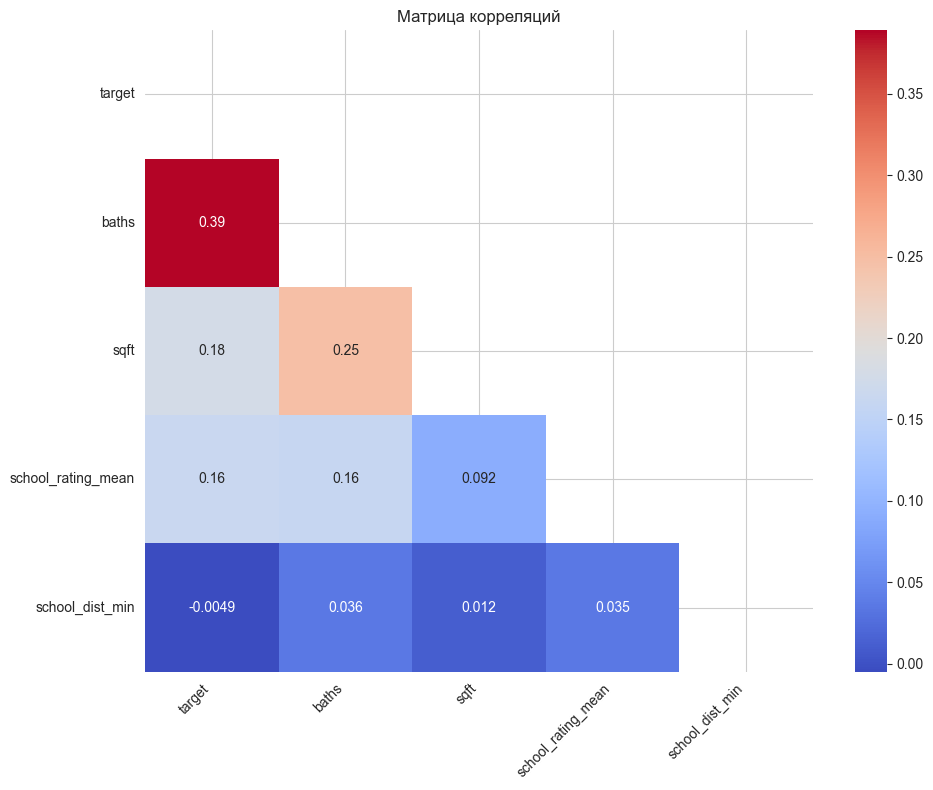

In [22]:
# Предполагается, что 'data' является DataFrame и содержит числовые признаки
num_features = ['target', 'baths', 'sqft', 'school_rating_mean', 'school_dist_min']
data_num = data[num_features]
# Вычисляем корреляционную матрицу
corr_matrix = data_num.corr()
# Выводим ранг и определитель матрицы корреляций
print('Ранг матрицы корреляций:', np.linalg.matrix_rank(corr_matrix))
print('Определитель матрицы корреляций: {:.7f}'.format(np.linalg.det(corr_matrix)))
# Создаем тепловую карту
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', mask=np.triu(np.ones_like(corr_matrix, dtype=bool)))
# Настройка осей
plt.xticks(ticks=np.arange(len(num_features)) + 0.5, labels=num_features, rotation=45, ha='right', fontsize=10)
plt.yticks(ticks=np.arange(len(num_features)) + 0.5, labels=num_features, rotation=0, va='center', fontsize=10)
# Отображаем график
plt.title('Матрица корреляций', fontsize=12)
plt.tight_layout()
plt.show()

- По рангу матрицы можем говорить что все признаки линейно независимы и нет полной мультиколлинеарности.
- В нашем случае определитель равен 0.7562493, что указывает на отсутствие сильной мультиколлинеарности. Это значение далеко от 0, что подтверждает, что признаки не являются линейно зависимыми.

## Анализ номинативных переменных

Посмотрим на распределение стоймости квартир в зависимости от значения номинативных переменных.

C:\Users\Koop_\AppData\Local\Temp\ipykernel_20764\1827680576.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=column, y=target_column, data=filtered_data, palette='Set3')


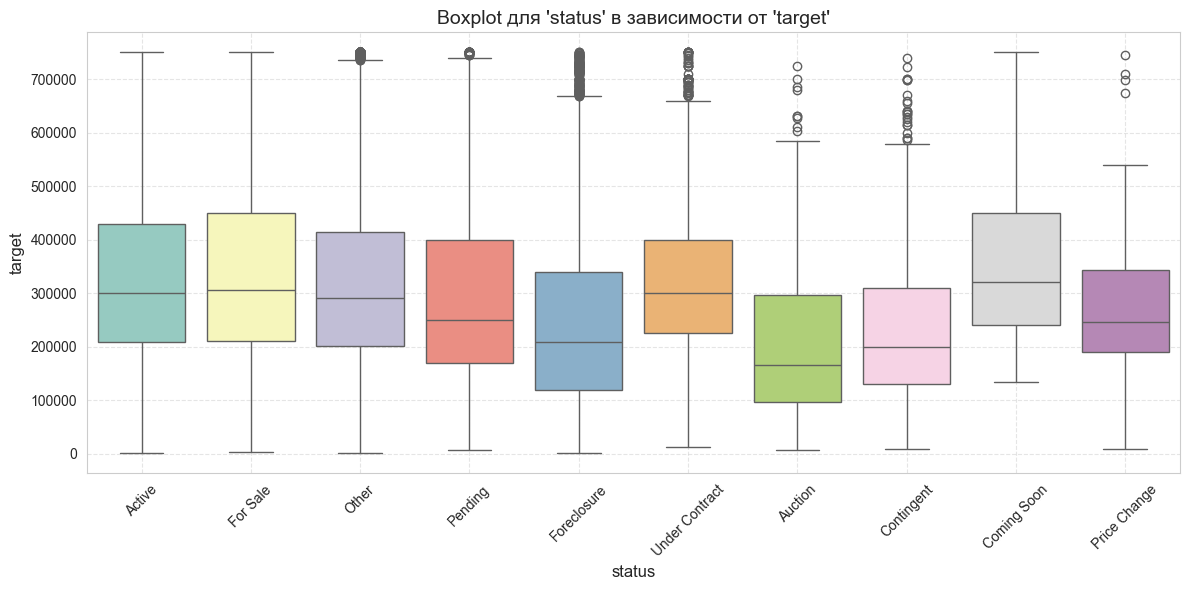

C:\Users\Koop_\AppData\Local\Temp\ipykernel_20764\1827680576.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=column, y=target_column, data=filtered_data, palette='Set3')


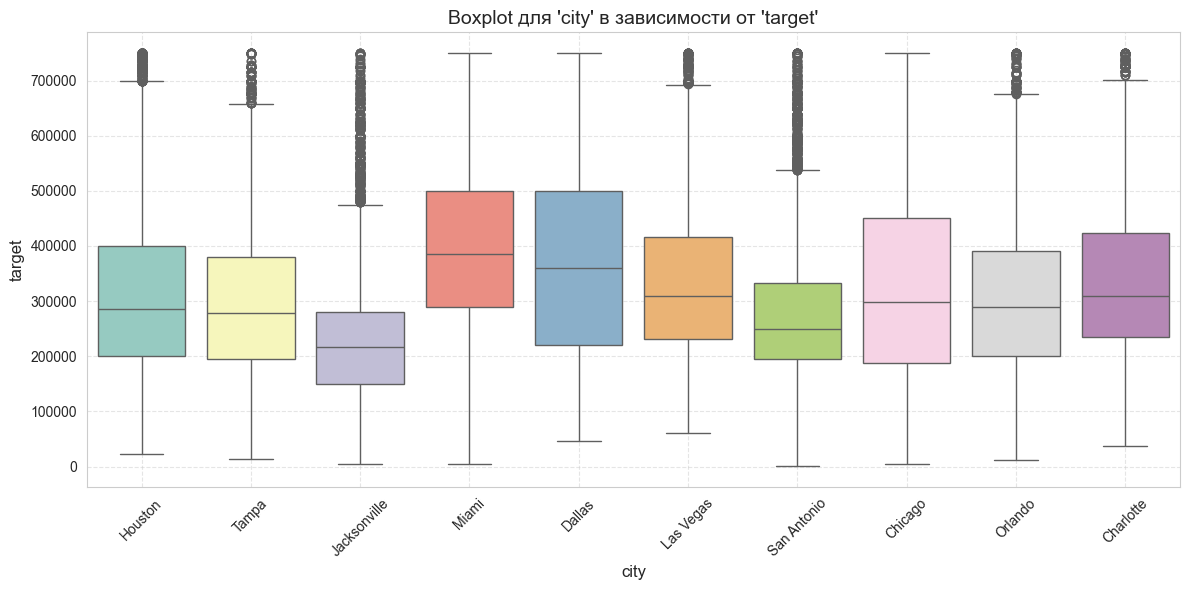

C:\Users\Koop_\AppData\Local\Temp\ipykernel_20764\1827680576.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=column, y=target_column, data=filtered_data, palette='Set3')


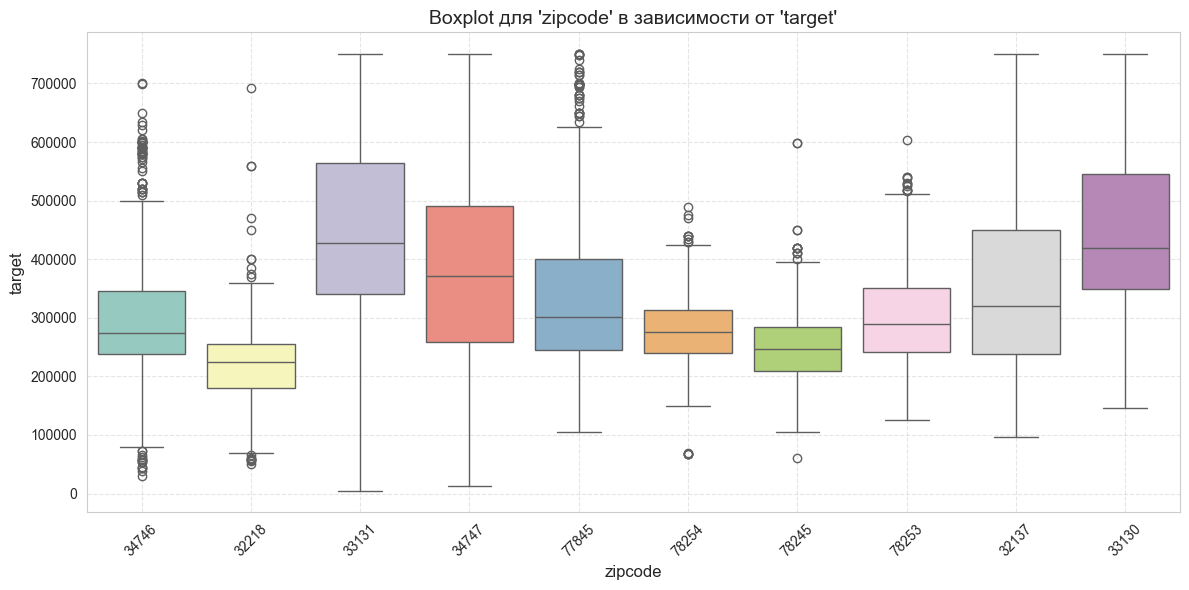

C:\Users\Koop_\AppData\Local\Temp\ipykernel_20764\1827680576.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=column, y=target_column, data=filtered_data, palette='Set3')


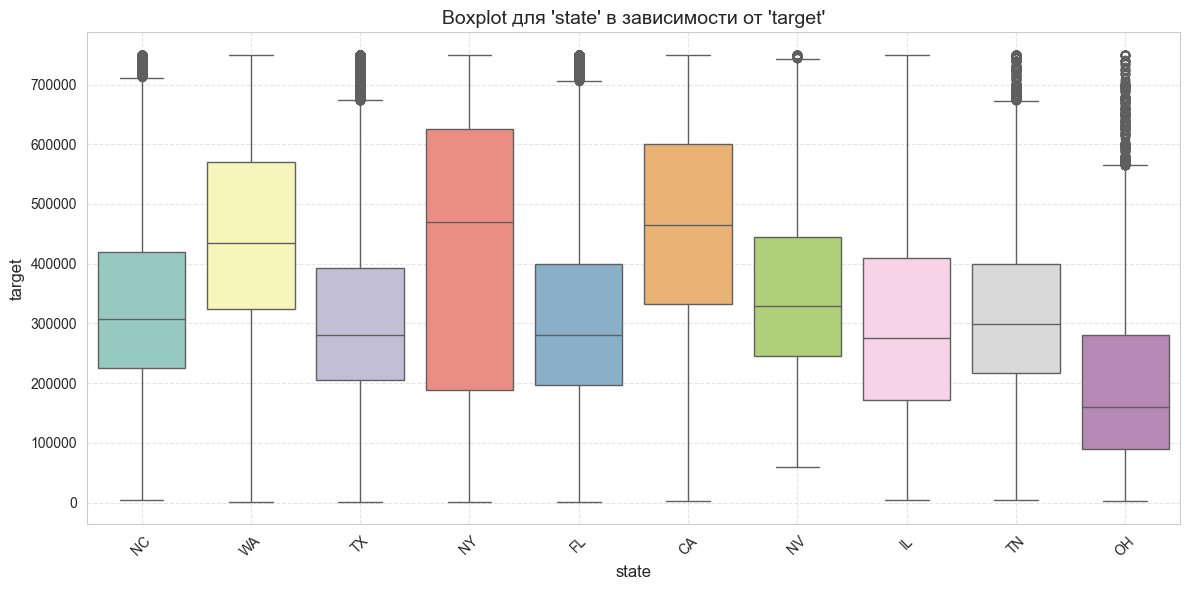

C:\Users\Koop_\AppData\Local\Temp\ipykernel_20764\1827680576.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=column, y=target_column, data=filtered_data, palette='Set3')


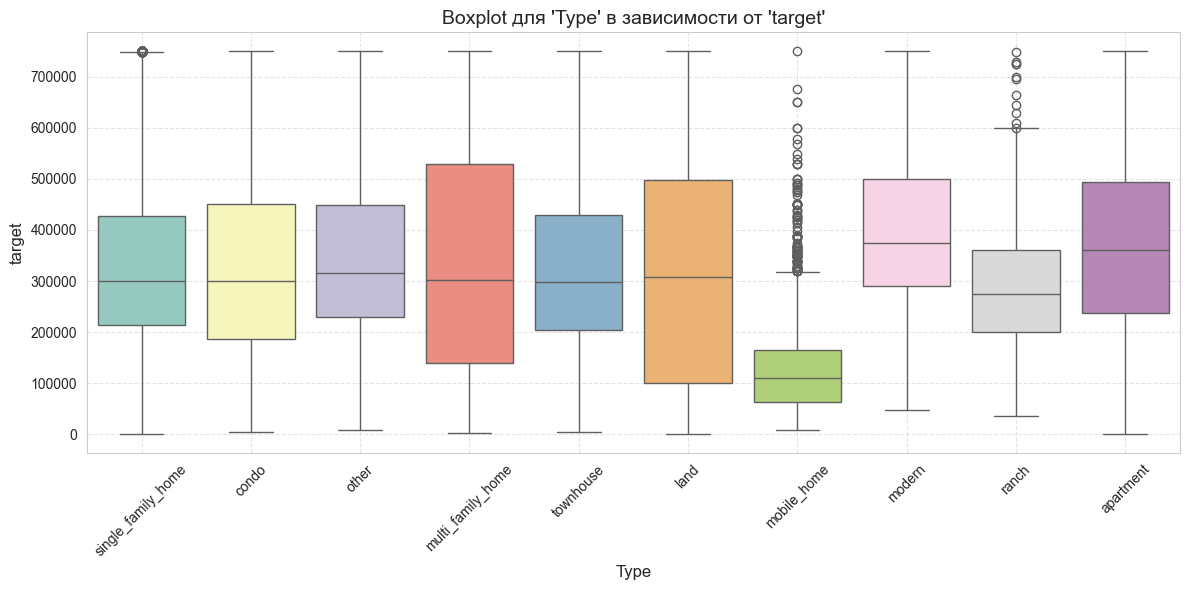

C:\Users\Koop_\AppData\Local\Temp\ipykernel_20764\1827680576.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=column, y=target_column, data=filtered_data, palette='Set3')


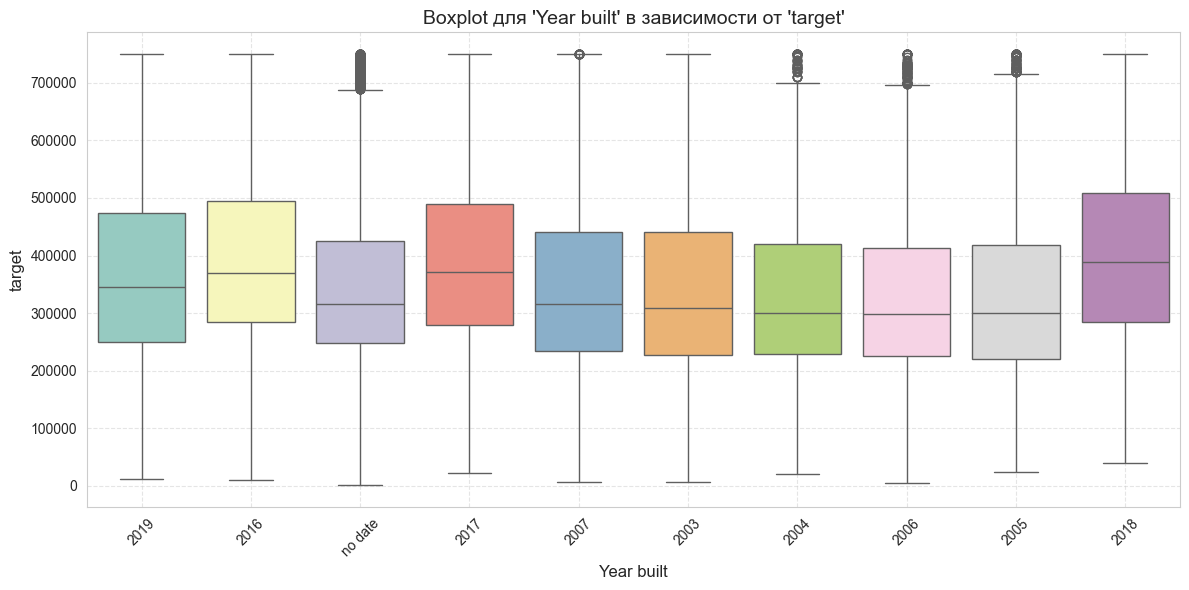

C:\Users\Koop_\AppData\Local\Temp\ipykernel_20764\1827680576.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=column, y=target_column, data=filtered_data, palette='Set3')


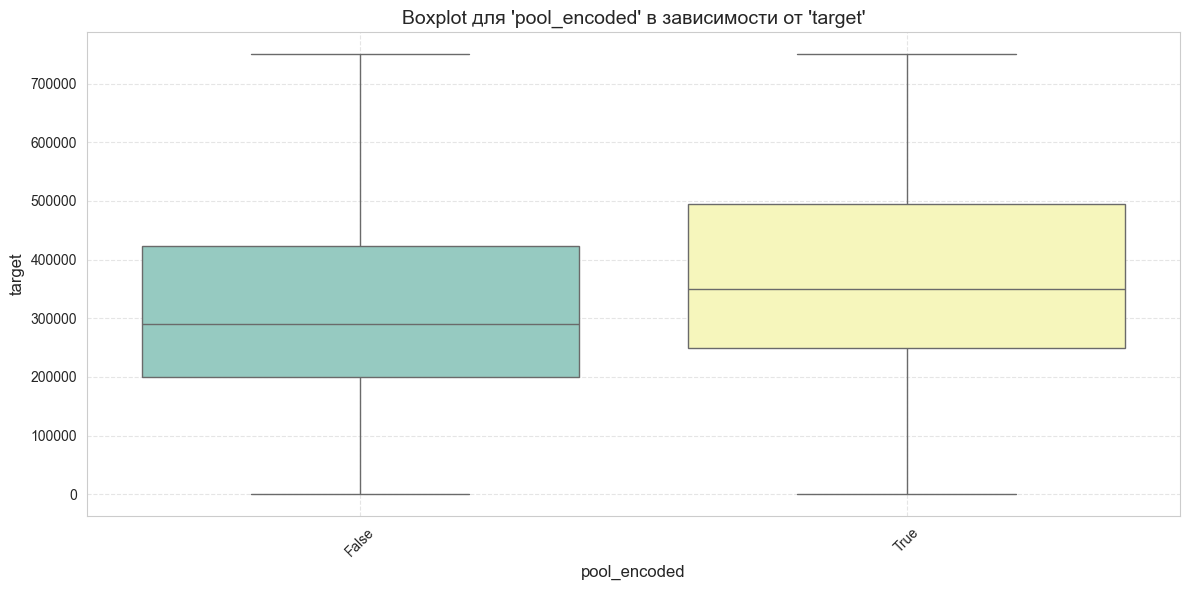

C:\Users\Koop_\AppData\Local\Temp\ipykernel_20764\1827680576.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=column, y=target_column, data=filtered_data, palette='Set3')


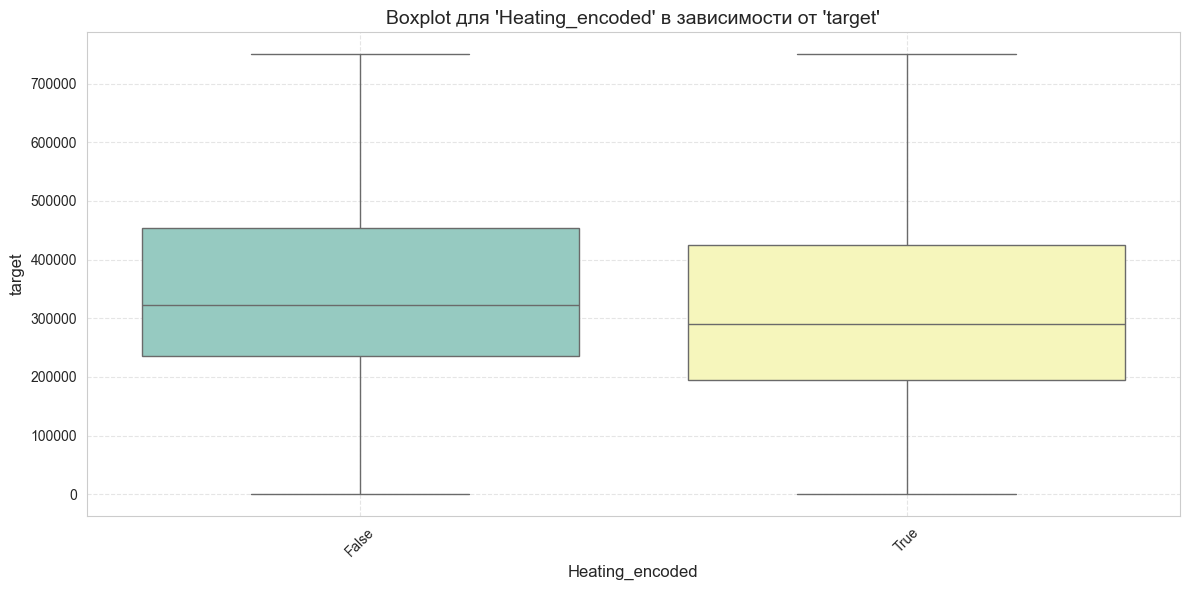

C:\Users\Koop_\AppData\Local\Temp\ipykernel_20764\1827680576.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=column, y=target_column, data=filtered_data, palette='Set3')


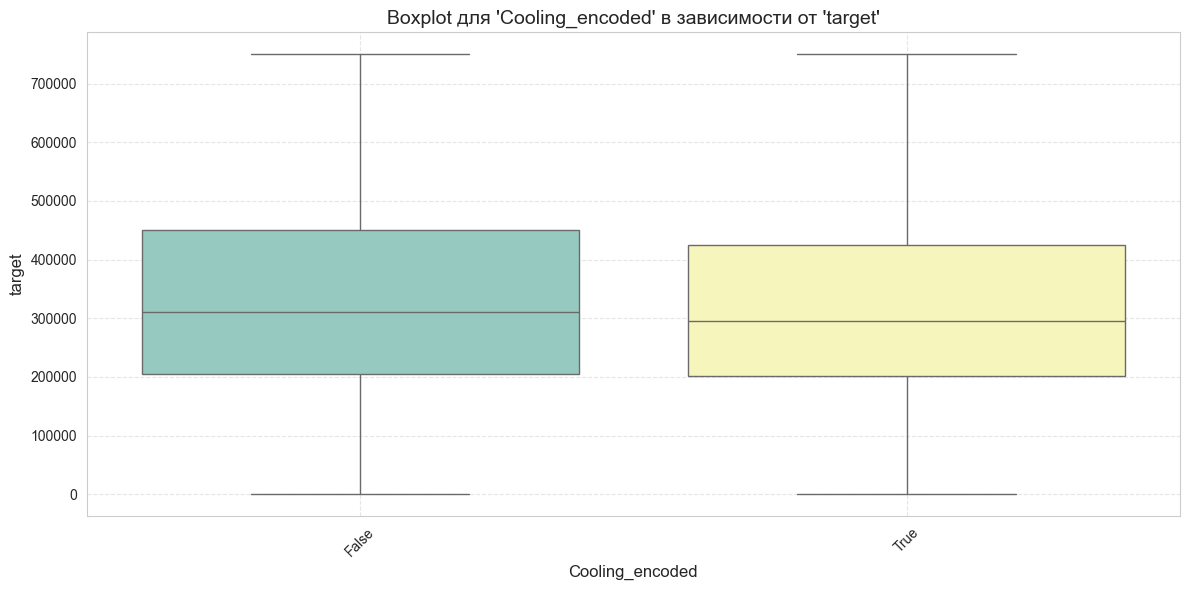

C:\Users\Koop_\AppData\Local\Temp\ipykernel_20764\1827680576.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=column, y=target_column, data=filtered_data, palette='Set3')


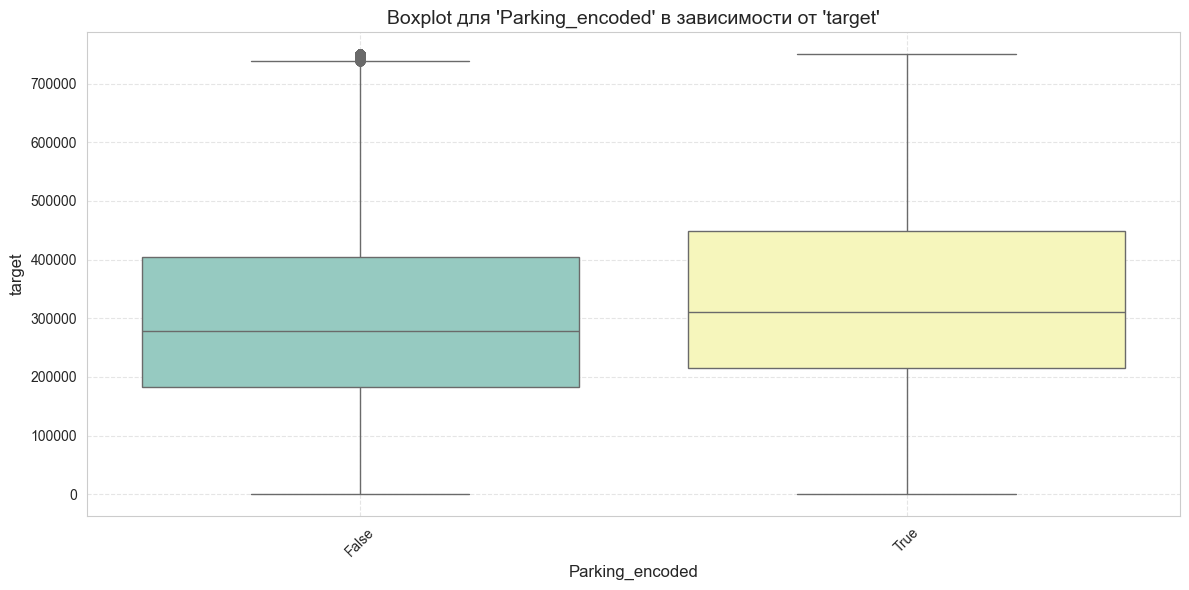

C:\Users\Koop_\AppData\Local\Temp\ipykernel_20764\1827680576.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=column, y=target_column, data=filtered_data, palette='Set3')


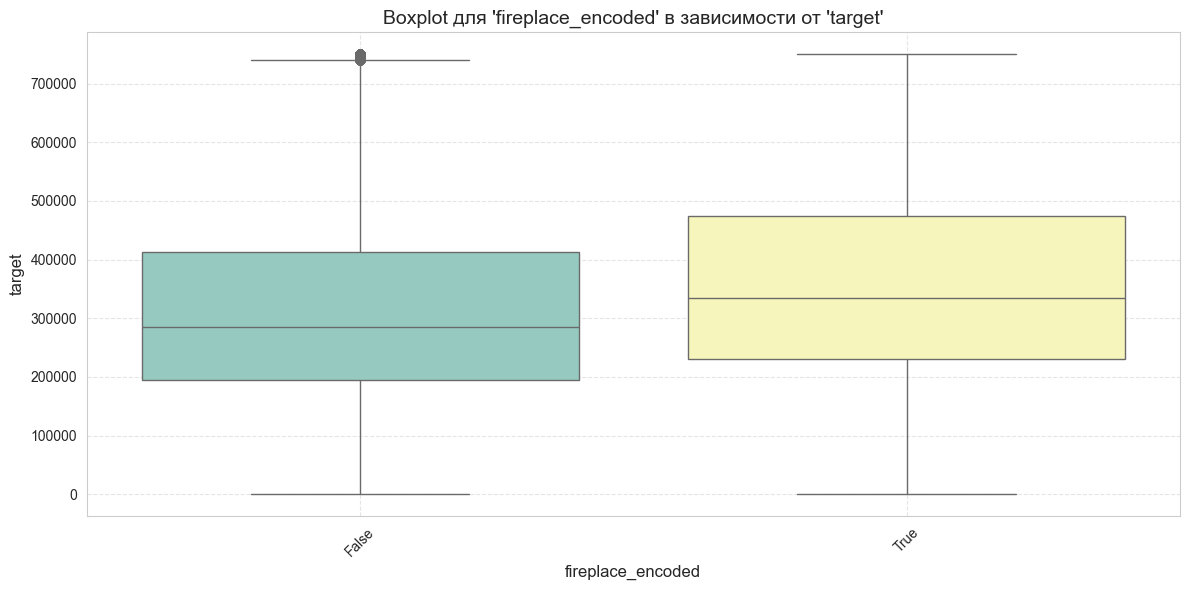

In [23]:
for col in chain(cat_features, bin_features):
    get_boxplot(col)

По графикам похоже, что все параметры, могут влиять на стоимость.

Проверим, есть ли статистическая разница в распределении оценок по номинативным признакам, с помощью теста Стьюдента. Проверим нулевую гипотезу о том, что распределения стоимости недвижимости по различным параметрам неразличимы:

In [27]:
def get_stat_dif(column, data, target='target', alpha=0.05):
    """
    Проверяет наличие статистически значимых различий в распределении целевой переменной 
    по категориям номинативного признака с использованием t-теста Стьюдента.
    :param column: Имя колонки для анализа
    :param data: DataFrame с данными
    :param target: Имя целевой переменной
    :param alpha: Уровень значимости
    """
    try:
        # Получаем топ-10 самых частых категорий
        top_categories = data[column].value_counts().index[:10]
        
        # Генерируем все возможные комбинации пар категорий
        combinations_all = list(combinations(top_categories, 2))
        
        # Применяем t-тест для каждой пары категорий
        for comb in combinations_all:
            group1 = data[data[column] == comb[0]][target]
            group2 = data[data[column] == comb[1]][target]
            
            # Проверяем, что обе группы не пустые
            if len(group1) > 0 and len(group2) > 0:
                # Вычисляем p-значение
                p_value = ttest_ind(group1, group2).pvalue
                
                # Применяем поправку Бонферрони
                if p_value <= alpha / len(combinations_all):
                    print(f'Найдены статистически значимые различия для колонки {column}')
                    break
    except Exception as e:
        print(f"Ошибка при обработке колонки {column}: {e}")
# Пример использования
for col in chain(cat_features, bin_features):
    get_stat_dif(col, data)

Найдены статистически значимые различия для колонки status
Найдены статистически значимые различия для колонки city
Найдены статистически значимые различия для колонки zipcode
Найдены статистически значимые различия для колонки state
Найдены статистически значимые различия для колонки Type
Найдены статистически значимые различия для колонки Year built
Найдены статистически значимые различия для колонки pool_encoded
Найдены статистически значимые различия для колонки Heating_encoded
Найдены статистически значимые различия для колонки Cooling_encoded
Найдены статистически значимые различия для колонки Parking_encoded
Найдены статистически значимые различия для колонки fireplace_encoded


Видим что все признаки являются значимыми

# Результаты EDA
## В результате EDA мы проделали следующую работу:

* Избавились от пропусков влияющих на целевую переменную.
* Избавились от выбросов.
* Провели корреляционный анализ числовых признаков.
* Посмотрели на распределение числовых признаков, в результате решили в дальнейшем нормализовать и логорифмировать числовые признаки.
* Провели анализ номинативных переменных.

Сохраним датасет для дальнейшего использования при обучении модели.


In [28]:
data.to_csv('data/data_model.csv', index=False)